In [1]:
# Импорт библиотек
import os
import time

import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]

############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine=1
steamVD_to_turbine=0
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,    
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)

start_time = time.time()

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

####ОГРАНИЧЕНИЯ НА РАБОТУ ПГУ
# ЕСЛИ ТЕПЛОФИКАЦИЯ (из документов по ПГУ-220Т)
# Gк_мин=4,44 кг/с вроде
# Nтурбины мин = 17,6 МВт
# ДЛЯ ВСЕХ РЕЖИМОВ (Из Трухния по ПГУ-450Т)
#Gвд_мин=25% от номинала
# Gнд_мин = 50% от номинала


Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 5.78 сек. ---
dQ/Qsumm -0.0014415661006680818
Fin турбоустановка:--- 0.08 сек. ---
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.7920139551555314
dQ/Q ПЕВД+ИВД+ЭВД -1.5997049418727685
dQ/Q ПЕВД+ИВД+ЭВД 0.7805763477625216
dQ/Q ПЕВД+ИВД+ЭВД -0.3808993689061506
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК -0.009116984399591525
Достигнуто макси

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,467.874546,0.1,873.833075,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,308.240590,0.1,696.370519,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,234.004421,0.1,616.043520,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,231.151825,0.1,612.982154,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,172.144272,0.1,550.032823,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,100.736268,0.1,474.681020,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592556,8.287662,3424.810703,62.478413,NaN,NaN
IVD-PEVD,300.284734,8.622408,2749.089253,62.478413,NaN,NaN
EVD-IVD,297.954092,8.622408,1333.276323,62.478413,NaN,NaN
PEN-EVD,162.838456,8.622408,692.426820,62.478413,NaN,NaN
BND-PEN,161.060794,0.635095,680.083888,62.478413,NaN,NaN
PPND-DROSND,206.834101,0.629432,2864.060781,14.470410,NaN,NaN
IND-PPND,161.060794,0.635095,2758.602602,14.470410,NaN,NaN
GPK-IND,157.156308,0.635095,663.167360,76.948823,NaN,NaN
GPK-REC,157.156308,0.635095,663.167360,91.282478,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,0.000000,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,1.453607,2.300213,8.803145,NaN,2.232369,NaN
DOOTB1,50.183933,5.231034,82.253807,5.322269,NaN,NaN
DOOTB2,1.549612,2.986521,60.316492,2.897945,24.010828,NaN
DROSND-TURBND,1.961992,0.256533,10.688791,0.504308,2.332112,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,1.453607,0.066770,1.421751,NaN,0.080123,NaN
ENDOFVD,1.453607,0.514094,11.457105,NaN,4.263524,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.771167,0.794192,0.971008,0.712436
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,150.750600,NaN,33.348086
DK,NaN,6.269747,NaN,NaN
Turbine,57.333364,NaN,NaN,NaN
Tots1,37.183895,NaN,NaN,0.847997
Tots2,14.824072,NaN,NaN,0.683706
Tots3,0.255509,NaN,NaN,0.638570
Tots4,5.069888,NaN,NaN,0.180100


In [7]:
heaters

,Qw,Qg,KPD
PEVD,42220.217930,42646.684777,0.99
IVD,88458.413960,89351.933293,0.99
EVD,40039.989423,40444.433761,0.99
PPND,1525.976010,1541.389910,0.99
IND,31377.875721,31694.823960,0.99
GPK,37560.041467,37939.435825,0.99
SP2,83.953526,NaN,0.99
SP1,73.997116,NaN,0.99
OD,6.439194,NaN,0.99
ASW,NaN,NaN,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,15,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592556,8.287662,3424.810703,62.478413,6.743810,NaN
IVD-PEVD,300.284734,8.622408,2749.089253,62.478413,NaN,NaN
EVD-IVD,297.954092,8.622408,1333.276323,62.478413,NaN,NaN
PEN-EVD,162.838456,8.622408,692.426820,62.478413,NaN,NaN
BND-PEN,161.060794,0.635095,680.083888,62.478413,NaN,NaN
PPND-DROSND,206.834101,0.629432,2864.060781,14.470410,6.975150,NaN
IND-PPND,161.060794,0.635095,2758.602602,14.470410,NaN,NaN
GPK-IND,157.156308,0.635095,663.167360,76.948823,NaN,NaN
GPK-REC,157.156308,0.635095,663.167360,91.282478,NaN,NaN


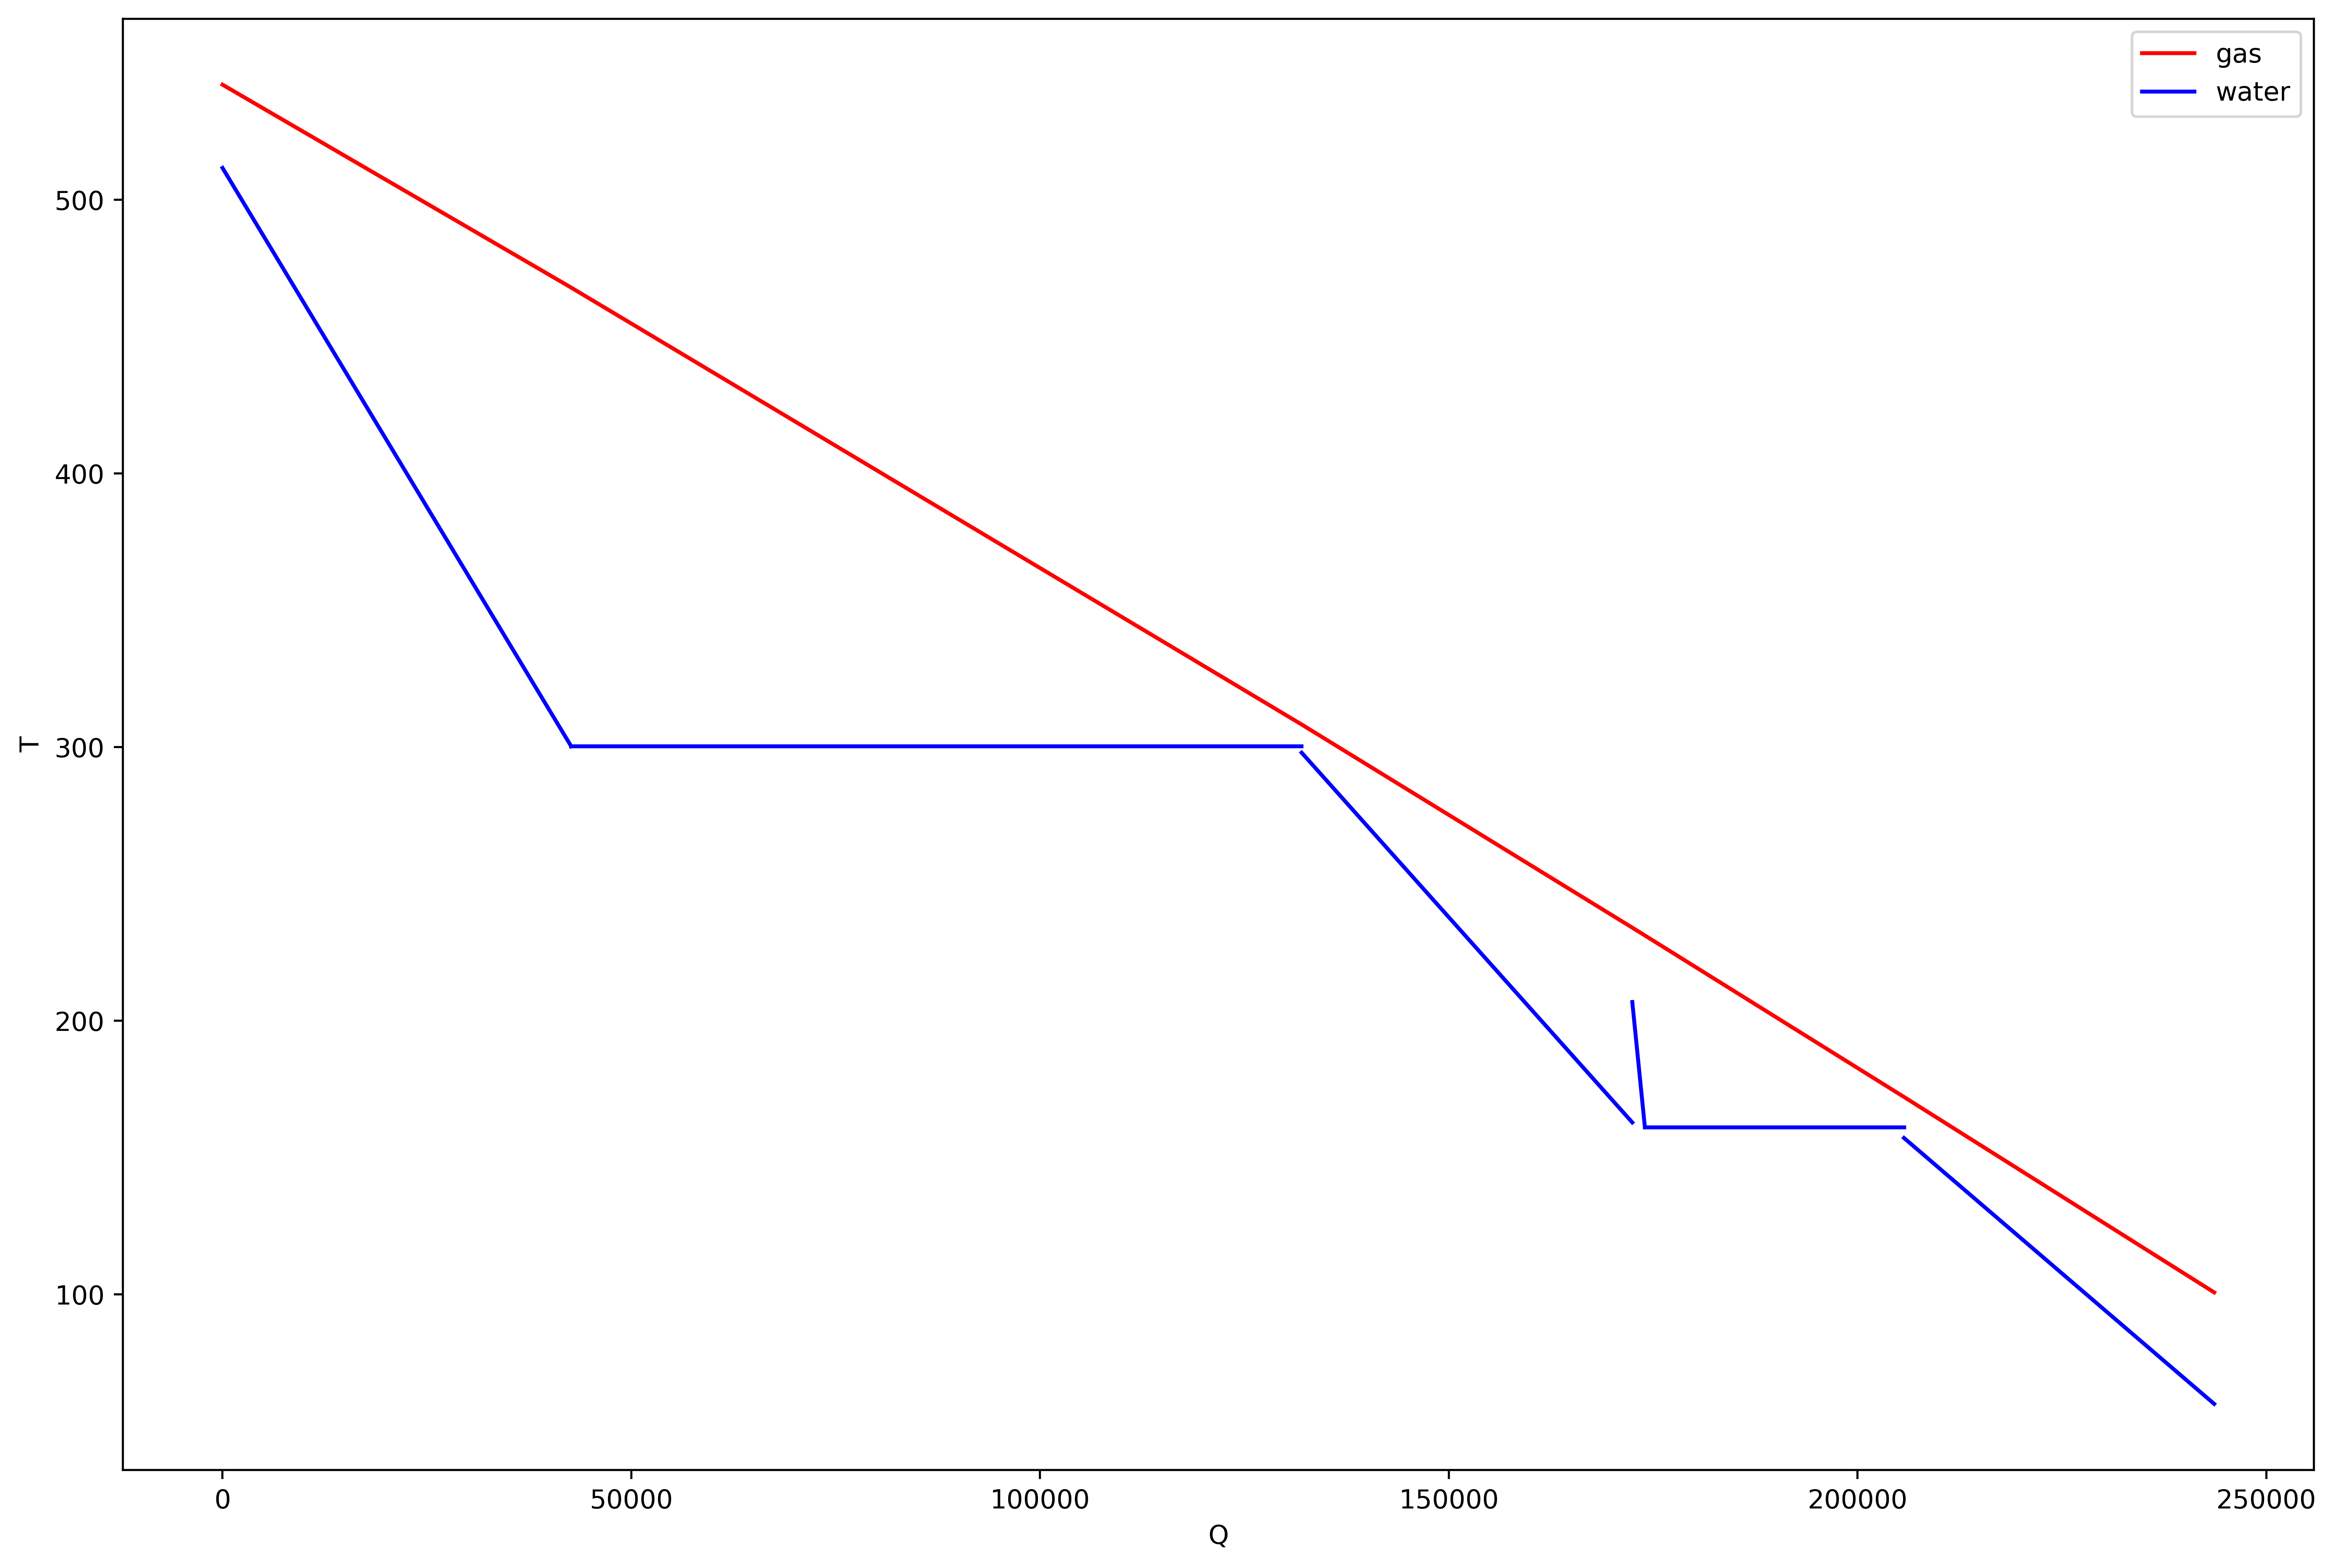

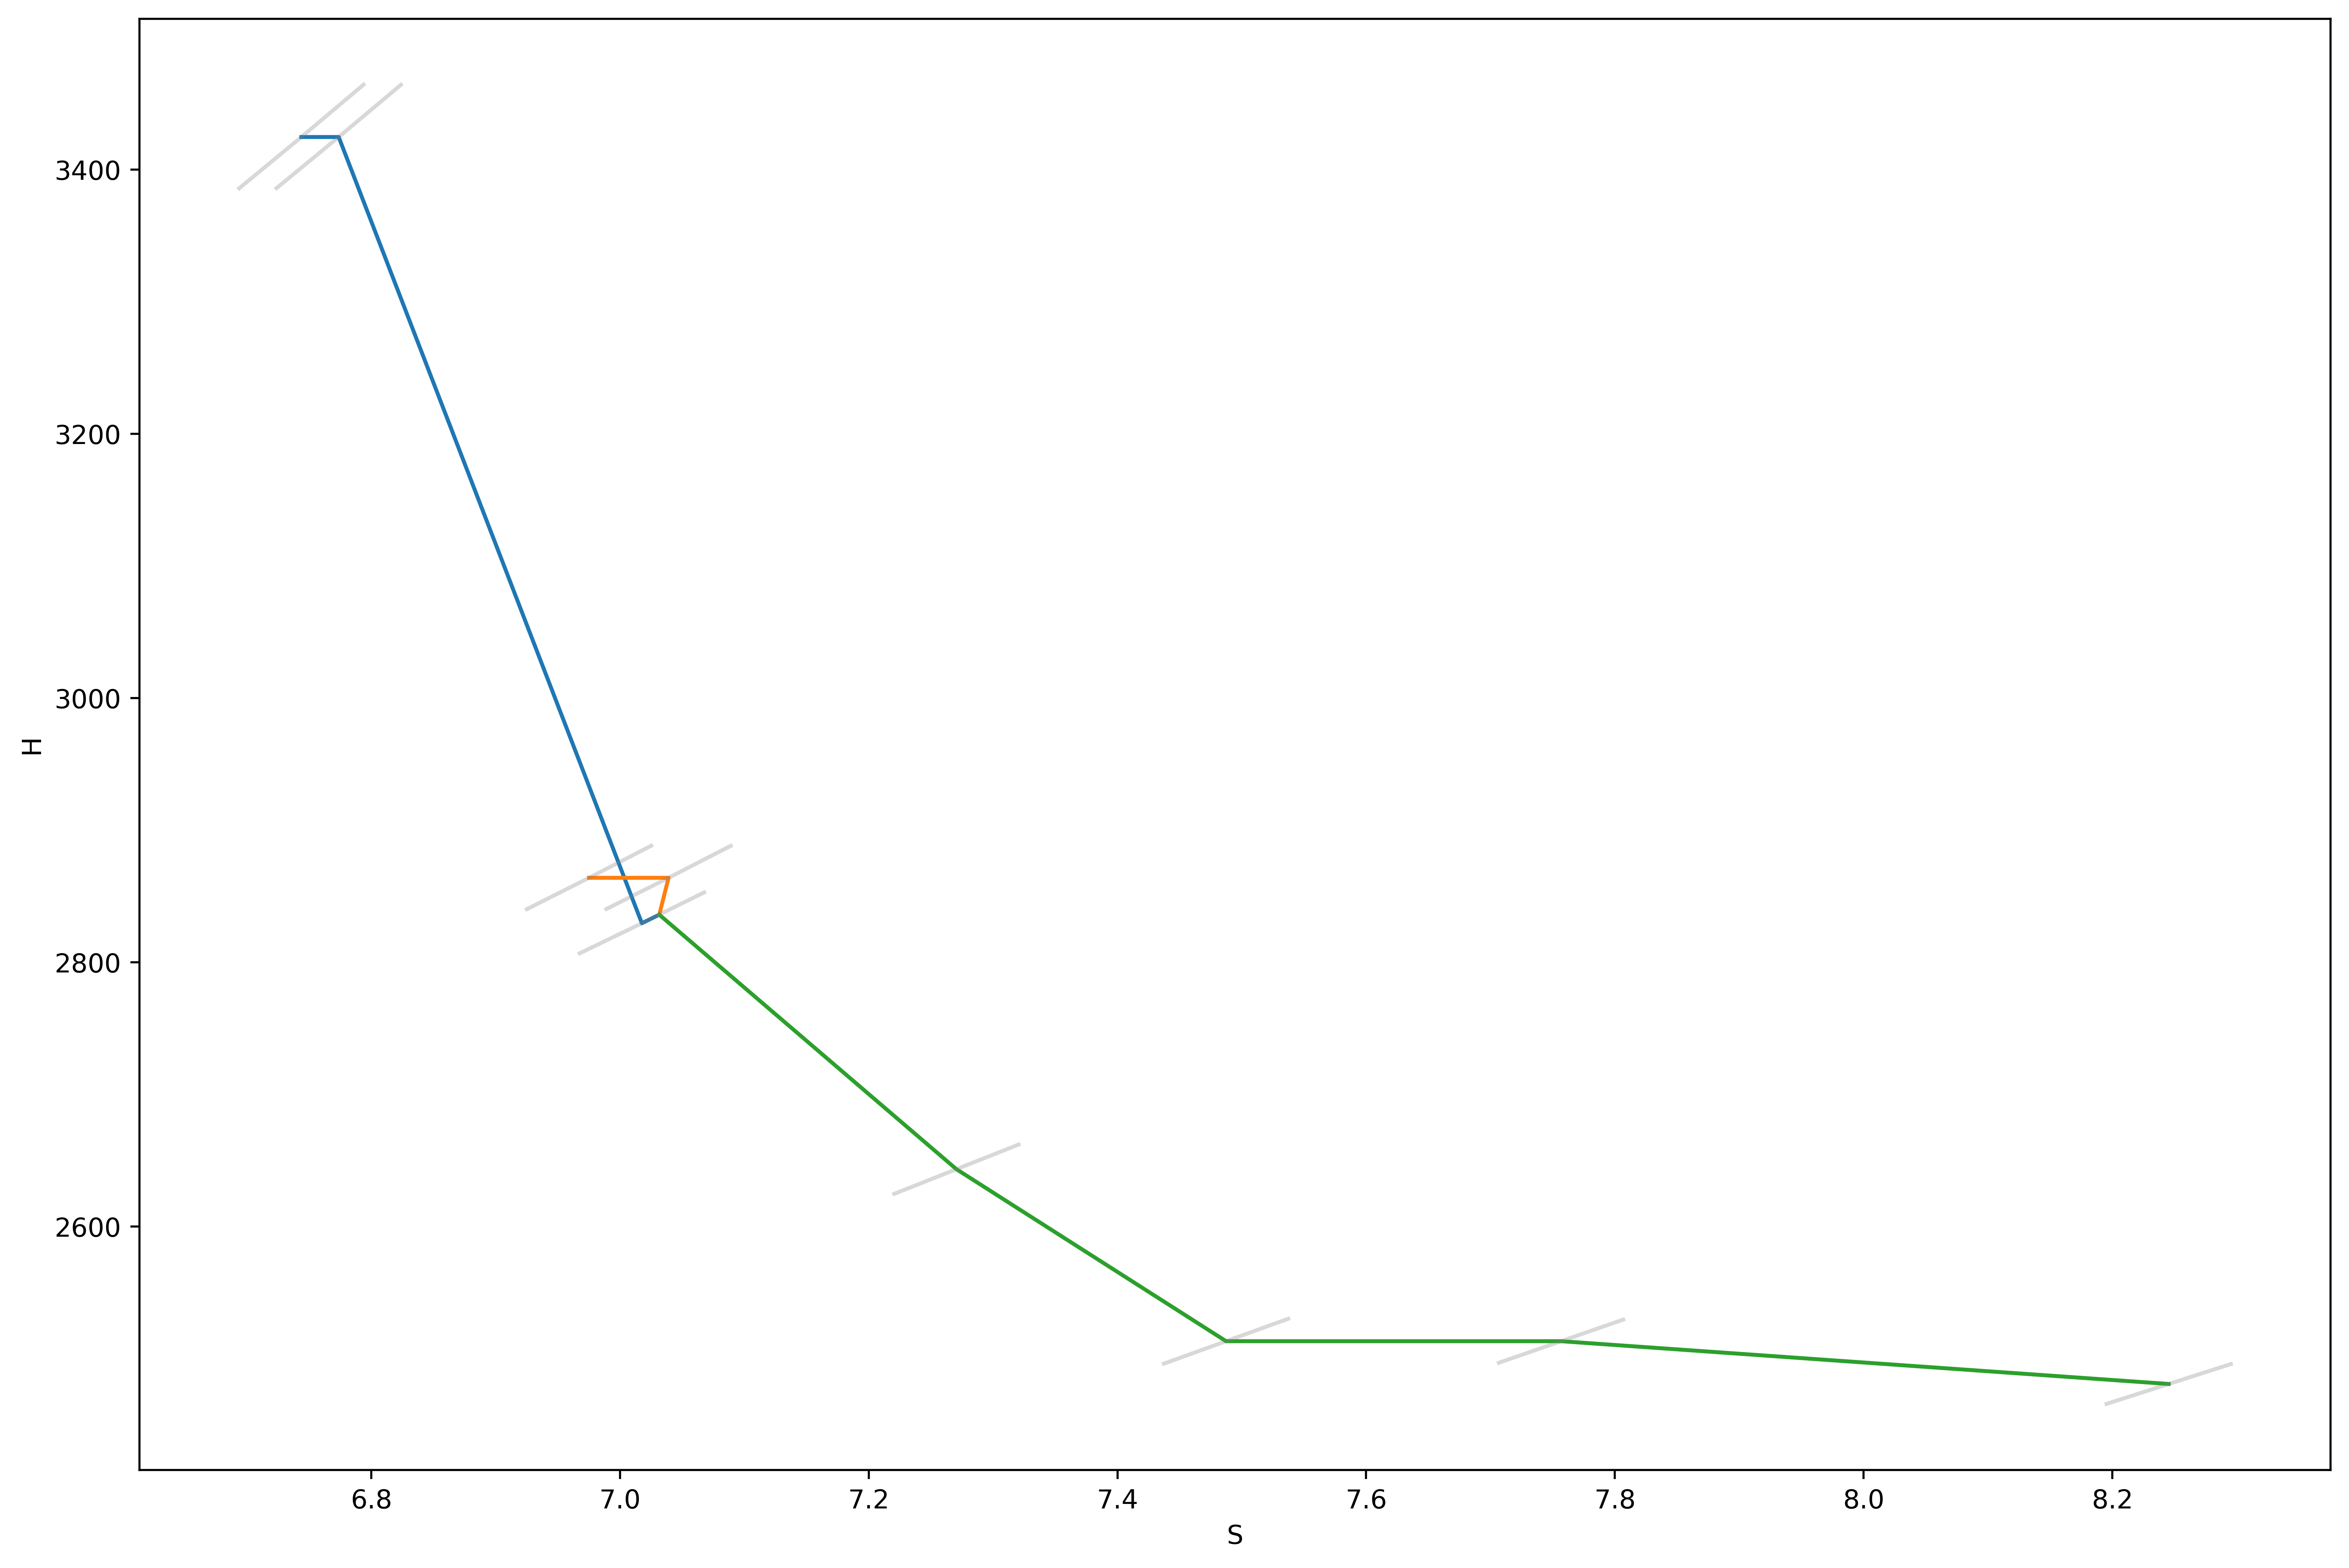

In [9]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams

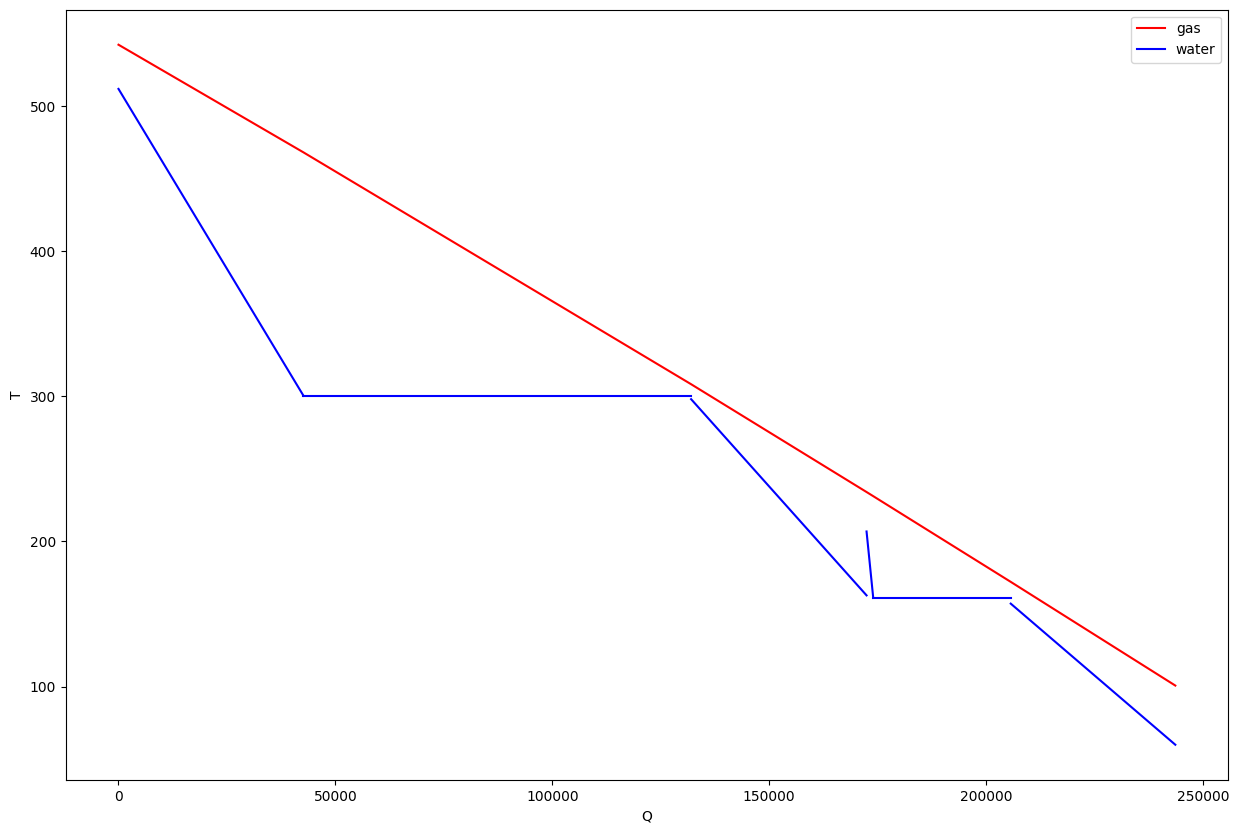

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
Qg = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Qw = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Tg = gas_streams.loc["GTU-PEVD":"GPK-out", "T"]
Tw = [
    water_streams.loc["PEVD-DROSVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["EVD-IVD", "T"],
    water_streams.loc["PEN-EVD", "T"],
    water_streams.loc["PPND-DROSND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["GPK-REC", "T"],
    water_streams.loc["REC-GPK", "T"],
]
plt.plot(Qg, Tg, color="red")
plt.plot(Qw[0:2], Tw[0:2], color="blue")
plt.plot(Qw[1:3], Tw[1:3], color="blue")
plt.plot(Qw[3:5], Tw[3:5], color="blue")
plt.plot(Qw[5:7], Tw[5:7], color="blue")
plt.plot(Qw[6:8], Tw[6:8], color="blue")
plt.plot(Qw[8:10], Tw[8:10], color="blue")
plt.xlabel("Q")
plt.ylabel("T")
plt.legend(["gas", "water"])
plt.show()

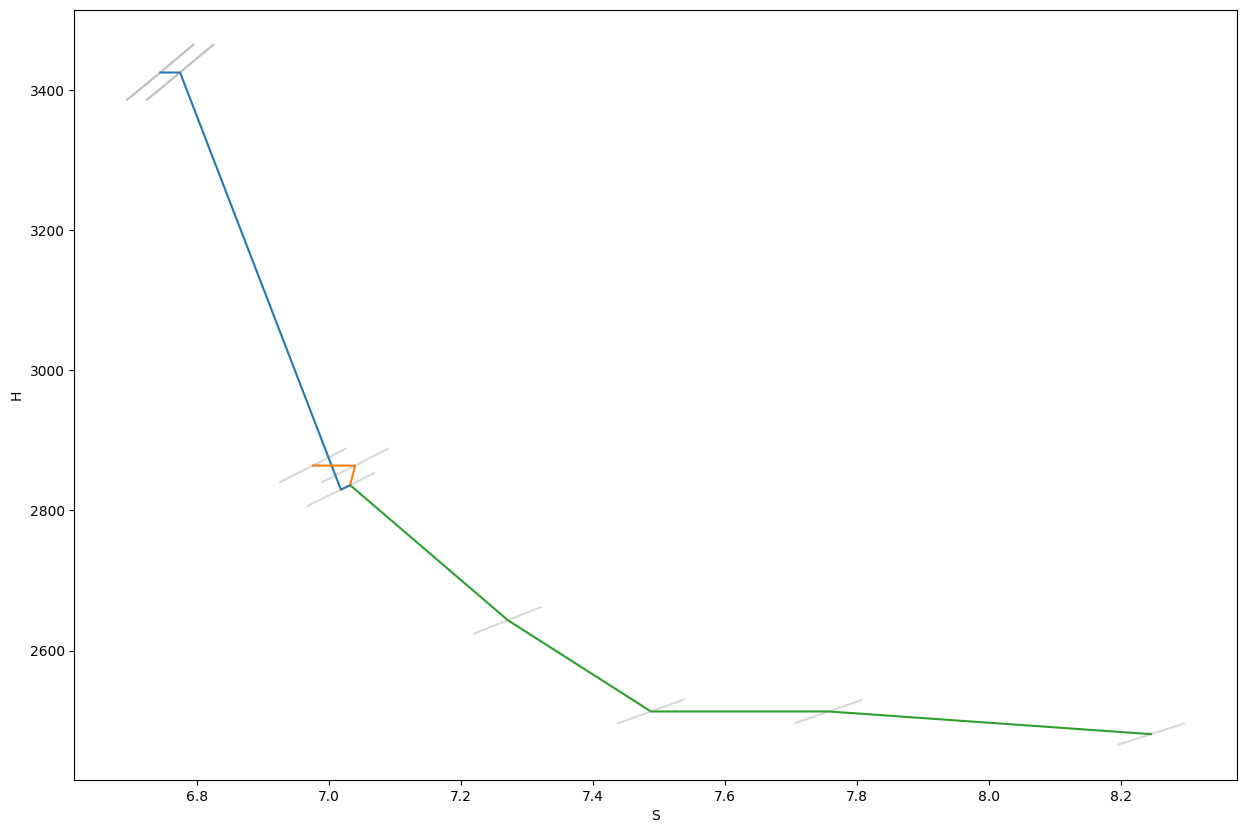

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592556,8.287662,3424.810703,62.478413,6.743810,NaN
IVD-PEVD,300.284734,8.622408,2749.089253,62.478413,NaN,NaN
EVD-IVD,297.954092,8.622408,1333.276323,62.478413,NaN,NaN
PEN-EVD,162.838456,8.622408,692.426820,62.478413,NaN,NaN
BND-PEN,161.060794,0.635095,680.083888,62.478413,NaN,NaN
PPND-DROSND,206.834101,0.629432,2864.060781,14.470410,6.975150,NaN
IND-PPND,161.060794,0.635095,2758.602602,14.470410,NaN,NaN
GPK-IND,157.156308,0.635095,663.167360,76.948823,NaN,NaN
GPK-REC,157.156308,0.635095,663.167360,91.282478,NaN,NaN


In [11]:
import matplotlib.pyplot as plt

water_streams.at["PEVD-DROSVD", "S"] = water.p_h(
    water_streams.at["PEVD-DROSVD", "P"], water_streams.at["PEVD-DROSVD", "H"]
)["s"]
water_streams.at["PPND-DROSND", "S"] = water.p_h(
    water_streams.at["PPND-DROSND", "P"], water_streams.at["PPND-DROSND", "H"]
)["s"]

plt.figure(figsize=(15, 10))
Hvd = [
    water_streams.at["PEVD-DROSVD", "H"],
    water_streams.at["DROSVD-TURBVD", "H"],
    water_streams.at["ENDOFVD", "H"],
    water_streams.at["SMESHEND", "H"],
]
Svd = [
    water_streams.at["PEVD-DROSVD", "S"],
    water_streams.at["DROSVD-TURBVD", "S"],
    water_streams.at["ENDOFVD", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hsm = [
    water_streams.at["PPND-DROSND", "H"],
    water_streams.at["DROSND-TURBND", "H"],
    water_streams.at["SMESHEND", "H"],
]
Ssm = [
    water_streams.at["PPND-DROSND", "S"],
    water_streams.at["DROSND-TURBND", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hnd = [
    water_streams.at["SMESHEND", "H"],
    water_streams.at["DOOTB2", "H"],
    water_streams.at["DOOTB1", "H"],
    water_streams.at["INCND", "H"],
    water_streams.at["INKOND", "H"],
]
Snd = [
    water_streams.at["SMESHEND", "S"],
    water_streams.at["DOOTB2", "S"],
    water_streams.at["DOOTB1", "S"],
    water_streams.at["INCND", "S"],
    water_streams.at["INKOND", "S"],
]

# Давления
stream = "PEVD-DROSVD"
H1 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S1 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H2 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S2 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "ENDOFVD"
H3 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S3 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PEVD-DROSVD"
H4 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S4 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H5 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S5 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PPND-DROSND"
H6 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S6 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSND-TURBND"
H7 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S7 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]

stream = "DOOTB2"
H8 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S8 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DOOTB1"
H9 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S9 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INCND"
H10 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S10 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INKOND"
H11 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S11 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]


plt.plot(Svd, Hvd)
plt.plot(Ssm, Hsm)
plt.plot(Snd, Hnd)
plt.plot(S1, H1,S2,H2,S3,H3,
    S4,
    H4,
    S5,
    H5,
    S6,
    H6,
    S7,
    H7,
    S8,
    H8,
    S9,
    H9,
    S10,
    H10,
    S11,
    H11,
    color="gray",
    alpha=0.3,
)
plt.xlabel("S")
plt.ylabel("H")
plt.show()
water_streams